In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.optimizers.legacy import Adam

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

/var/folders/r4/7pf11ys10v3_zn69hlpg60_h0000gn/T/ipykernel_21503/2494615717.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Project Objective
This study endeavors to construct a predictive model for estimating the salaries of Data Science positions worldwide, denominated in US dollars (USD).

### Reading Data From Source

In [2]:
data = pd.read_csv('./SalarayDataSet/ds_salaries.csv')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Describing Features

1. **work_year**: The year the salary was paid.
2. **experience_level**: The experience level in the job during the year
3. **employment_type**: The type of employment for the role
4. **job_title**: The role worked in during the year.
5. **salary**: The total gross salary amount paid.
6. **salary_currency**: The currency of the salary paid as an ISO 4217 currency code.
7. **salary_in_usd**: The salary in USD
8. **employee_residence**: Employee's primary country of residence in during the work year as an ISO 3166 country code.
9. **remote_ratio**: The overall amount of work done remotely
10. **company_location**: The country of the employer's main office or contracting branch
11. **company_size**: The median number of people that worked for the company during the year

### Data Cleaning

In [3]:
data.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

# Exploratory Data Analysis (EDA) - Salary Dataset

## Mean Salary by Position

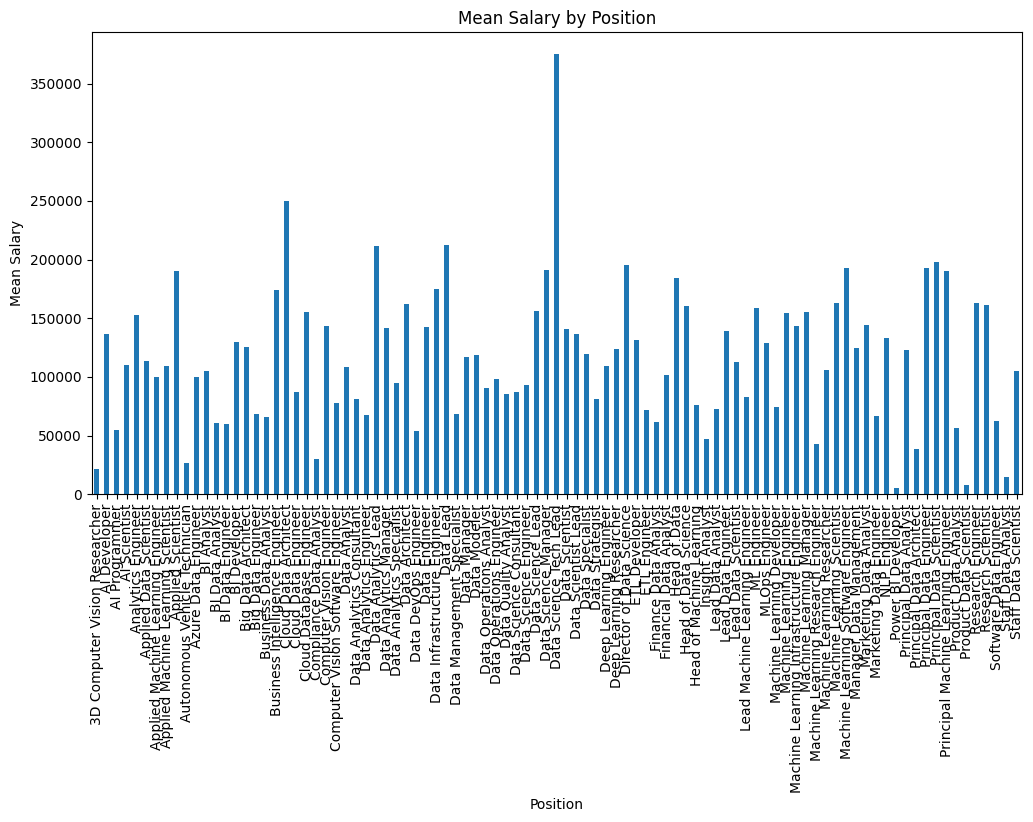

In [4]:
mean_salary_by_position = data.groupby('job_title')['salary_in_usd'].mean()

plt.figure(figsize=(12,6))
mean_salary_by_position.plot(kind='bar')
plt.title('Mean Salary by Position')
plt.xlabel('Position')
plt.ylabel('Mean Salary')
plt.show()

## Distribution of Salary (in USD)


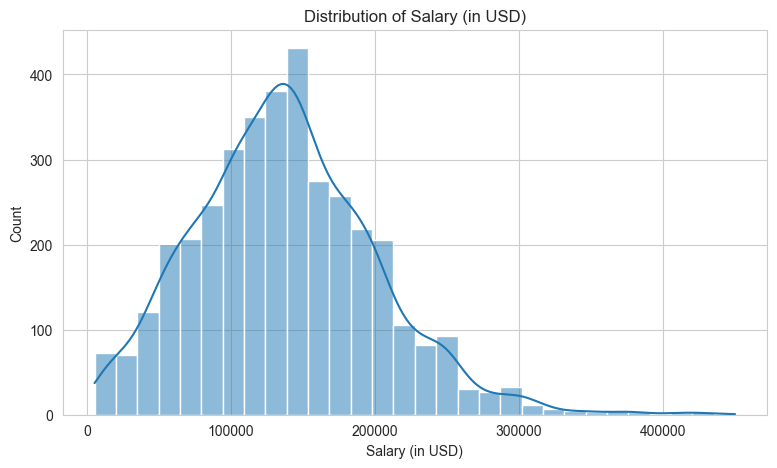

In [5]:
sns.set_style("whitegrid")

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['salary_in_usd'], kde=True, bins=30)
plt.title('Distribution of Salary (in USD)')
plt.xlabel('Salary (in USD)')
plt.ylabel('Count')

plt.show()

## Distribution of Experience Level

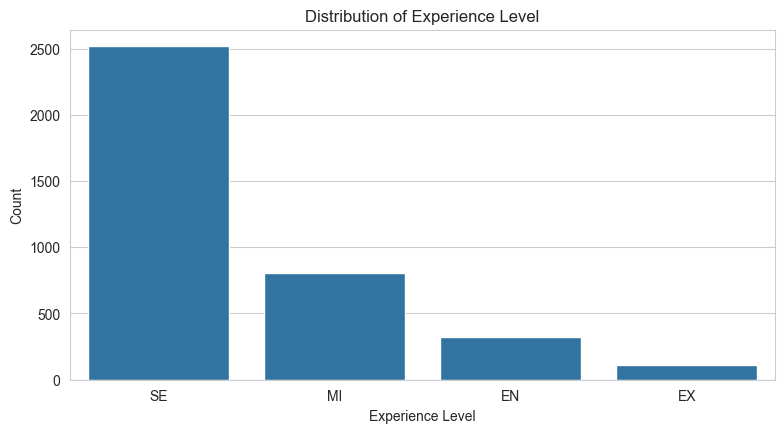

In [6]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='experience_level', data=data, order=data['experience_level'].value_counts().index)
plt.title('Distribution of Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Count')
plt.show()

# Data Modification
In this section, we normalize the dataset we identify numeric and categorical features in the dataset.

## Overview of dataset columns Dtype

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


## Data Encoding
In order to normalize the data for the training, validation and testing of the model, we identify numeric and categorical features in the dataset and apply appropriate preprocessing transformations.

In [8]:
columns_to_encode = [column for column in data.columns if data[column].dtype == 'object']

for column in columns_to_encode:
    print(column,
          ", ",data[column].nunique())

experience_level ,  4
employment_type ,  4
job_title ,  93
salary_currency ,  20
employee_residence ,  78
company_location ,  72
company_size ,  3


In [9]:
for col in data.columns:
  col_counts = data[col].value_counts()
  print(col_counts)

work_year
2023    1785
2022    1664
2021     230
2020      76
Name: count, dtype: int64
experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64
employment_type
FT    3718
PT      17
CT      10
FL      10
Name: count, dtype: int64
job_title
Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: count, Length: 93, dtype: int64
salary
100000    112
150000    100
120000     99
160000     85
130000     85
         ... 
241871      1
93919       1
385000      1
225900      1
412000      1
Name: count, Length: 815, dtype: int64
salary_

We can observe that the data set has 7 not numerical features which should be converted:
1. experience_level

2. employment_type

3.  job_title

4. salary_currency

5. employee_residence

6. company_location

7. company_size

### Normalizing Salary Columns
This section normalizes the 'salary' and 'salary_in_usd' columns by dividing their values by 100,000. Normalization is performed to scale the values within a similar range, which can help improve the convergence of machine learning algorithms during training.

In [10]:
cols_to_normalize = ['salary', 'salary_in_usd']
data[cols_to_normalize] = data[cols_to_normalize] / 100000

data[cols_to_normalize]

,salary,salary_in_usd
0,0.800,0.85847
1,0.300,0.30000
2,0.255,0.25500
3,1.750,1.75000
4,1.200,1.20000
...,...,...
3750,4.120,4.12000
3751,1.510,1.51000
3752,1.050,1.05000
3753,1.000,1.00000


## Data Preprocessing and Splitting

In this section, we preprocess the dataset and split it into training and validation sets. The following steps are performed:

1. **Feature-Target Separation:** We separate the feature matrix `data_X` from the target variable `y` in the dataset.

    ```python
    data_X = data.drop('salary_in_usd', axis=1)
    y = data['salary_in_usd']
    ```

2. **Numeric and Categorical Feature Processing:** We identify numeric and categorical features in the dataset and apply appropriate preprocessing transformations.

    ```python
    numeric_features = data_X.select_dtypes(include=[np.number])
    numeric_transformer = StandardScaler()

    categorical_features = data_X.select_dtypes(include=['object'])
    categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features.columns),
            ('cat', categorical_transformer, categorical_features.columns)
        ])
    ```

3. **Dataset Splitting:** We split the dataset into training and validation sets using a specified test size and random state.

    ```python
    indices = data.index
    train_indices, valid_indices = train_test_split(indices, test_size=0.4, random_state=42)
    ```

4. **Applying Transformers:** We apply the preprocessing transformers to the training and validation feature sets.

    ```python
    x_train, y_train = data_X.loc[train_indices, :], y.loc[train_indices]
    x_valid, y_valid = data_X.loc[valid_indices, :], y.loc[valid_indices]

    X_train_preprocessed = preprocessor.fit_transform(x_train)
    X_valid_preprocessed = preprocessor.transform(x_valid)
    ```

These steps ensure that our dataset is properly preprocessed and ready for training and validation of machine learning models.

In [11]:
data_X = data.drop('salary_in_usd', axis=1)
y = data['salary_in_usd']

numeric_features = data_X.select_dtypes(include=[np.number])
numeric_transformer = StandardScaler()

categorical_features = data_X.select_dtypes(include=['object'])
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.columns),
        ('cat', categorical_transformer, categorical_features.columns)
    ])

indices = data.index
train_indices, rest_indices = train_test_split(indices, test_size=0.3, random_state=42)
valid_indices, test_indices  = train_test_split(rest_indices, test_size=0.5, random_state=42)
x_train, y_train = data_X.loc[train_indices, :], y.loc[train_indices]
x_valid, y_valid = data_X.loc[valid_indices, :], y.loc[valid_indices]
x_test, y_test = data_X.loc[test_indices, :], y.loc[test_indices]

X_train_preprocessed = preprocessor.fit_transform(x_train)
X_valid_preprocessed = preprocessor.transform(x_valid)
X_test_preprocessed = preprocessor.transform(x_test)

## Convolutional Neural Network (CNN) Modeling

This section outlines the implementation of Convolutional Neural Network (CNN) model. The process involves the following steps:

1. **CNN Model Definition:** CNN model is defined using the Keras Sequential API. The model consists of convolutional layers with ReLU activation functions, max-pooling layers for downsampling, and dense layers for regression.

    ```python
    cnn_model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(248, 1)),
        MaxPooling1D(2),

        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),

        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),

        Flatten(),

        Dense(64, activation='relu'),

        Dense(1)
    ])
    ```

2. **Model Compilation:** The CNN model is compiled using the Adam optimizer, mean squared error (MSE) as the loss function, and mean absolute error (MAE) as the metric.

    ```python
    cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='mean_squared_error',
                      metrics=['mae'])
    ```

3. **Model Training:** The CNN model is trained on the preprocessed training data. The `fit` method is used to train the models with specified epochs, batch size, and verbose mode.

    ```python
    cnn_model_history = cnn_model.fit(X_train_preprocessed, y_train,
                        validation_data=(X_valid_preprocessed, y_valid),
                        epochs=400,
                        batch_size=32,
                        verbose=2,
                        )
    ```

4. **Evaluation:** After training, the performance of the model is evaluated on the validation set using MSE and MAE metrics.

    ```python
    cnn_model_evalutaion_result = cnn_model.evaluate(X_valid_preprocessed, y_valid, verbose=0)
    ```

These steps illustrate the process of implementing CNN model, providing insights into model architecture, compilation, training, and evaluation.

In [12]:
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(248, 1)),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(1)
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_squared_error',
                  metrics=['mae'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 246, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 123, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 121, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 60, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 58, 128)           24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 29, 128)           0

In [13]:
cnn_model_history = cnn_model.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2)

cnn_model_evalutaion_result = cnn_model.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Epoch 1/400
83/83 - 1s - loss: 0.8310 - mae: 0.7113 - val_loss: 0.2852 - val_mae: 0.4176 - 910ms/epoch - 11ms/step
Epoch 2/400
83/83 - 1s - loss: 0.2907 - mae: 0.4121 - val_loss: 0.2525 - val_mae: 0.3870 - 542ms/epoch - 7ms/step
Epoch 3/400
83/83 - 1s - loss: 0.2688 - mae: 0.3955 - val_loss: 0.2483 - val_mae: 0.3848 - 524ms/epoch - 6ms/step
Epoch 4/400
83/83 - 1s - loss: 0.2620 - mae: 0.3894 - val_loss: 0.2422 - val_mae: 0.3769 - 538ms/epoch - 6ms/step
Epoch 5/400
83/83 - 1s - loss: 0.2554 - mae: 0.3830 - val_loss: 0.2367 - val_mae: 0.3723 - 508ms/epoch - 6ms/step
Epoch 6/400
83/83 - 1s - loss: 0.2495 - mae: 0.3785 - val_loss: 0.2318 - val_mae: 0.3617 - 525ms/epoch - 6ms/step
Epoch 7/400
83/83 - 1s - loss: 0.2432 - mae: 0.3718 - val_loss: 0.2265 - val_mae: 0.3581 - 567ms/epoch - 7ms/step
Epoch 8/400
83/83 - 1s - loss: 0.2418 - mae: 0.3708 - val_loss: 0.2236 - val_mae: 0.3547 - 560ms/epoch - 7ms/step
Epoch 9/400
83/83 - 1s - loss: 0.2399 - mae: 0.3688 - val_loss: 0.2281 - val_mae: 0.369

# Results
## Training and Validation Loss Plot
This plot shows the training and validation loss over epochs during the training of the CNN model.

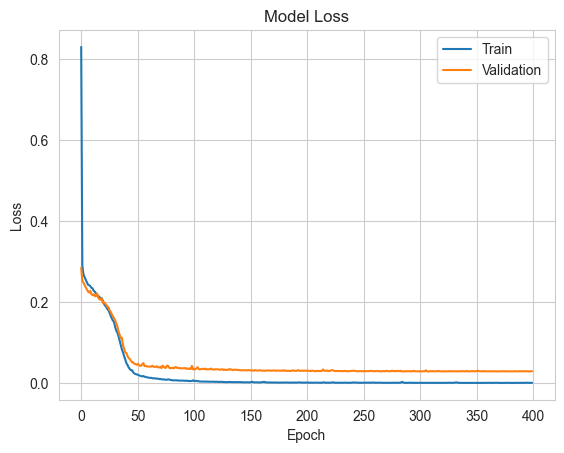

In [14]:
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Training and Validation Mean Absolute Error (MAE) Plot
This plot displays the training and validation mean absolute error (MAE) over epochs. MAE measures the average magnitude of errors between predicted and actual values.

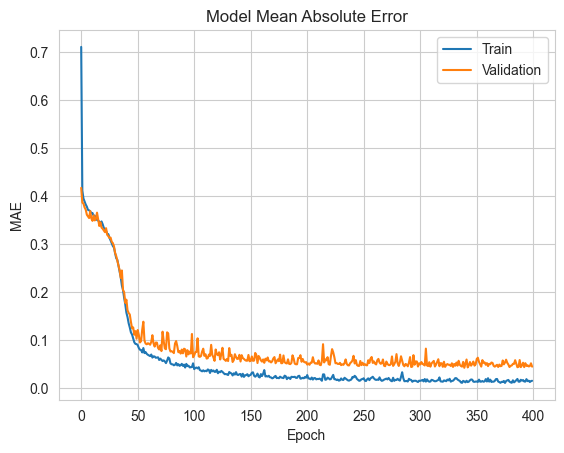

In [15]:
plt.plot(cnn_model_history.history['mae'])
plt.plot(cnn_model_history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Test Loss Bar Plot
This bar plot represents the loss achieved by the CNN model on the test dataset.

In [16]:
test_loss, test_mae= cnn_model.evaluate(X_test_preprocessed, y_test)

18/18 [==============================] - 0s 7ms/step - loss: 0.0218 - mae: 0.0403


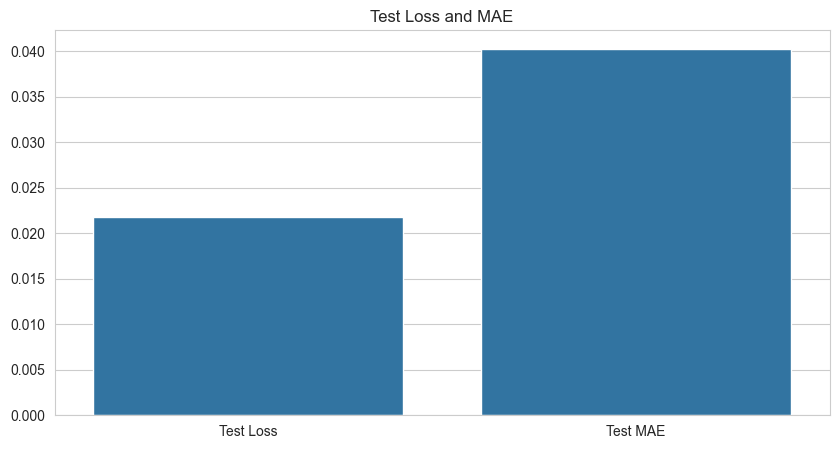

In [34]:
plt.figure(figsize=(10, 5))
sns.barplot(x=['Test Loss', 'Test MAE'], y=[test_loss, test_mae])
plt.title('Test Loss and MAE')
plt.show()